In [33]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import difflib
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


By looking at the GET requests sent by the browser when loading the world rankings page (using Postman), we have found the file that contains the data we need. We first send a GET request to receive it, and then turn it into a DataFrame and select only the columns that we need.

In [34]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
table_body = r.json()
df = pd.DataFrame(table_body['data'])
column_names = ['rank', 'name', 'location', 'url', 'scores_overall', 'scores_teaching', 'scores_research', 
   'scores_citations', 'scores_industry_income', 'scores_international_outlook', 'stats_number_students',
   'stats_student_staff_ratio', 'stats_pc_intl_students']
ranking_complete=df[column_names]

In [35]:
ranking_complete

,rank,name,location,url,scores_overall,scores_teaching,scores_research,scores_citations,scores_industry_income,scores_international_outlook,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students
0,1,University of Oxford,United Kingdom,/world-university-rankings/university-oxford,94.3,86.7,99.5,99.1,63.7,95.0,"20,409",11.2,38%
1,2,University of Cambridge,United Kingdom,/world-university-rankings/university-cambridge,93.2,87.8,97.8,97.5,51.5,93.0,"18,389",10.9,35%
2,=3,California Institute of Technology,United States,/world-university-rankings/california-institut...,93.0,90.3,97.5,99.5,92.6,59.7,"2,209",6.5,27%
3,=3,Stanford University,United States,/world-university-rankings/stanford-university,93.0,89.1,96.7,99.9,60.5,77.6,"15,845",7.5,22%
4,5,Massachusetts Institute of Technology,United States,/world-university-rankings/massachusetts-insti...,92.5,87.3,91.9,100.0,88.4,87.6,"11,177",8.7,34%
5,6,Harvard University,United States,/world-university-rankings/harvard-university,91.8,84.2,98.4,99.7,46.4,79.7,"20,326",8.9,26%
6,7,Princeton University,United States,/world-university-rankings/princeton-university,91.1,85.7,93.9,99.6,58.0,78.7,"7,955",8.3,24%
7,8,Imperial College London,United Kingdom,/world-university-rankings/imperial-college-lo...,89.2,81.7,88.7,96.7,71.6,96.6,"15,857",11.4,55%
8,9,University of Chicago,United States,/world-university-rankings/university-chicago,88.6,85.3,90.1,99.4,39.8,69.6,"13,525",6.2,25%
9,=10,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,/world-university-rankings/eth-zurich-swiss-fe...,87.7,76.4,92.0,94.3,60.3,98.1,"19,233",14.6,38%


All columns are of type 'object' right now, which is not what we want. In addition, some columns have certain characteristics:
* The stats_pc_intl_students column which is the percentage of international students, has a % sign.
* Values in stats_number_students have commas.
* In all of the score columns, in some rows we have values of the form a-b where a and b are numbers. We will take their average as the actual score.
* The rank column includes three types of irregularity: =i indicates a tie at rank i (we will remove the =), i-j indicates a rank range (we will take the average as the rank), and i+ indicates a rank above i (again we will simply remove the +). 

In [36]:
ranking_complete.loc[:,'stats_pc_intl_students'] = ranking_complete['stats_pc_intl_students'].apply(lambda x: float(x.strip('%'))/100.0)
ranking_complete.loc[:,'stats_number_students'] = ranking_complete.loc[:,'stats_number_students'].replace(',','',regex=True).values
ranking_complete.loc[:,'stats_number_students':'stats_student_staff_ratio'] = ranking_complete.loc[:,'stats_number_students':'stats_student_staff_ratio'].astype('float64')

C:\Users\asus\Anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\asus\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [37]:
dash_character = '–'
def fix_float_value(value):
    if (str(value).find(dash_character) == -1):
        return float(value)
    parts = str(value).split(dash_character)
    return (float(parts[0])+float(parts[1]))/2.0

def fix_int_value(value):
    value = str(value)
    if (value.find(dash_character) == -1):
        if (value.find('=') == -1):
            if (value.find('+') == -1):
                return int(value)
            else:
                return int(value.strip('+'))
        else:
            return int(value.strip('='))
    else:
        parts = value.split(dash_character)
        return int((int(parts[0])+float(parts[1]))/2.0)
    
score_columns = ['scores_overall', 'scores_teaching', 'scores_research', 
   'scores_citations', 'scores_industry_income', 'scores_international_outlook']
for col in score_columns:
    ranking_complete[col] = ranking_complete[col].apply(fix_float_value)

ranking_complete['rank'] = ranking_complete['rank'].apply(fix_int_value)
ranking_complete = ranking_complete[ranking_complete['rank'] <= 200]

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


To add the region (which is missing from our data), we use the data contained in the __other__ dataset. We also compute the total number of staff and total number of international students for each university (because they will be needed in the future for the aggregations over region or country).

In [38]:
topunis_data = pickle.load(open('topuniversities.p','rb'))
map_country = {u:v for u,v in zip(list(topunis_data['country']),list(topunis_data['region']))}
map_country['Luxembourg'] = 'Europe'
map_country['Russian Federation'] = 'Europe'
region = [map_country[c] for c in ranking_complete['location']]
ranking_complete['region'] = region
ranking_complete['total_staff'] = (ranking_complete['stats_number_students']/ranking_complete['stats_student_staff_ratio']).astype(int)
ranking_complete['total_intl_student'] = (ranking_complete['stats_number_students']*ranking_complete['stats_pc_intl_students']).astype(int)
ranking_w_region = ranking_complete

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

In [39]:
ranking_w_region.head()

,rank,name,location,url,scores_overall,scores_teaching,scores_research,scores_citations,scores_industry_income,scores_international_outlook,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,region,total_staff,total_intl_student
0,1,University of Oxford,United Kingdom,/world-university-rankings/university-oxford,94.3,86.7,99.5,99.1,63.7,95.0,20409.0,11.2,0.38,Europe,1822,7755
1,2,University of Cambridge,United Kingdom,/world-university-rankings/university-cambridge,93.2,87.8,97.8,97.5,51.5,93.0,18389.0,10.9,0.35,Europe,1687,6436
2,3,California Institute of Technology,United States,/world-university-rankings/california-institut...,93.0,90.3,97.5,99.5,92.6,59.7,2209.0,6.5,0.27,North America,339,596
3,3,Stanford University,United States,/world-university-rankings/stanford-university,93.0,89.1,96.7,99.9,60.5,77.6,15845.0,7.5,0.22,North America,2112,3485
4,5,Massachusetts Institute of Technology,United States,/world-university-rankings/massachusetts-insti...,92.5,87.3,91.9,100.0,88.4,87.6,11177.0,8.7,0.34,North America,1284,3800


Now we will calculate the best countries in terms of student to staff ratio (lowest considered best) and also in terms of percentage of international students (highest considered best):

In [40]:
ranking_w_region.sort_values(ascending=[False], by=['stats_pc_intl_students'])[['name','rank','stats_pc_intl_students']].head(20)

,name,rank,stats_pc_intl_students
24,London School of Economics and Political Science,25,0.71
178,University of Luxembourg,179,0.57
37,École Polytechnique Fédérale de Lausanne,38,0.55
7,Imperial College London,8,0.55
102,Maastricht University,103,0.50
15,University College London,16,0.49
143,University of St Andrews,143,0.48
23,Carnegie Mellon University,24,0.45
120,Queen Mary University of London,121,0.45
39,University of Hong Kong,40,0.42


In [41]:
ranking_w_region.sort_values(ascending=[True], by=['stats_student_staff_ratio'])[['name','rank','stats_student_staff_ratio']].head(20)

,name,rank,stats_student_staff_ratio
105,Vanderbilt University,105,3.3
109,University of Copenhagen,109,4.1
12,Johns Hopkins University,13,4.3
11,Yale University,12,4.3
153,University of Rochester,153,4.3
97,Emory University,98,4.4
16,Duke University,17,4.5
114,École Polytechnique,115,5.1
183,Scuola Normale Superiore di Pisa,184,5.2
101,University of Pittsburgh,100,5.9


Now we want similar stats aggregated on country/region.

As you can see below, in the top 200 universities, Luxembourg has the highest ratio of international students.

In [42]:
cols_list = ['name', 'total_staff', 'total_intl_student', 'stats_number_students']

def do_country_region_agg(df, col_name, columns_list):
    columns_list.append(col_name)
    df_agg = df[columns_list]
    df_agg = df_agg.groupby(col_name).sum()
    df_agg['ratio_intl_student'] = df_agg['total_intl_student']/df_agg['stats_number_students']
    df_agg['ratio_student_staff'] = df_agg['stats_number_students']/df_agg['total_staff']
    return df_agg

ranking_aggregated_country = do_country_region_agg(ranking_w_region, 'location', cols_list)
ranking_aggregated_country.sort_values(ascending=False, by='ratio_intl_student').head(20)

,total_staff,total_intl_student,stats_number_students,ratio_intl_student,ratio_student_staff
location,,,,,
Luxembourg,340,2832,4969.0,0.569934,14.614706
United Kingdom,44425,213045,596449.0,0.357189,13.425976
Hong Kong,4140,25157,77663.0,0.323925,18.759179
Australia,9937,83807,268630.0,0.311979,27.033310
Singapore,3364,17084,56101.0,0.304522,16.676873
Switzerland,10048,32743,107852.0,0.303592,10.733678
New Zealand,1614,8800,30348.0,0.289970,18.802974
Ireland,708,4362,16157.0,0.269976,22.820621
Austria,1700,9197,35375.0,0.259986,20.808824


And Denmark has the lowest student to staff ratio.

In [43]:
ranking_aggregated_country.sort_values(ascending=True, by='ratio_student_staff').head(20)

,total_staff,total_intl_student,stats_number_students,ratio_intl_student,ratio_student_staff
location,,,,,
Denmark,10596,9326,64110.0,0.145469,6.050396
Russian Federation,4004,6431,29236.0,0.219969,7.301698
Japan,6464,4398,48481.0,0.090716,7.500155
Italy,157,132,1205.0,0.109544,7.675159
Switzerland,10048,32743,107852.0,0.303592,10.733678
United States,152317,280338,1705533.0,0.164370,11.197260
Taiwan,2761,2540,31758.0,0.079980,11.502354
South Africa,1775,3739,20775.0,0.179976,11.704225
China,21388,22879,253911.0,0.090106,11.871657


In [44]:
ranking_aggregated_country.describe()

,total_staff,total_intl_student,stats_number_students,ratio_intl_student,ratio_student_staff
count,27.000000,27.000000,2.700000e+01,27.000000,27.000000
mean,12900.851852,36775.666667,1.833059e+05,0.210223,16.433724
std,29301.785826,65392.247316,3.419531e+05,0.108363,7.954066
min,157.000000,132.000000,1.205000e+03,0.079980,6.050396
25%,1897.500000,4833.000000,3.105300e+04,0.136383,11.603290
50%,4140.000000,9326.000000,6.303500e+04,0.182654,14.614706
75%,10322.000000,28950.000000,1.851475e+05,0.279973,18.781076
max,152317.000000,280338.000000,1.705533e+06,0.569934,38.209566


And here are bar charts for the stats we calculated (1st one is intl. student ratio, 2nd one is student/staff ratio):

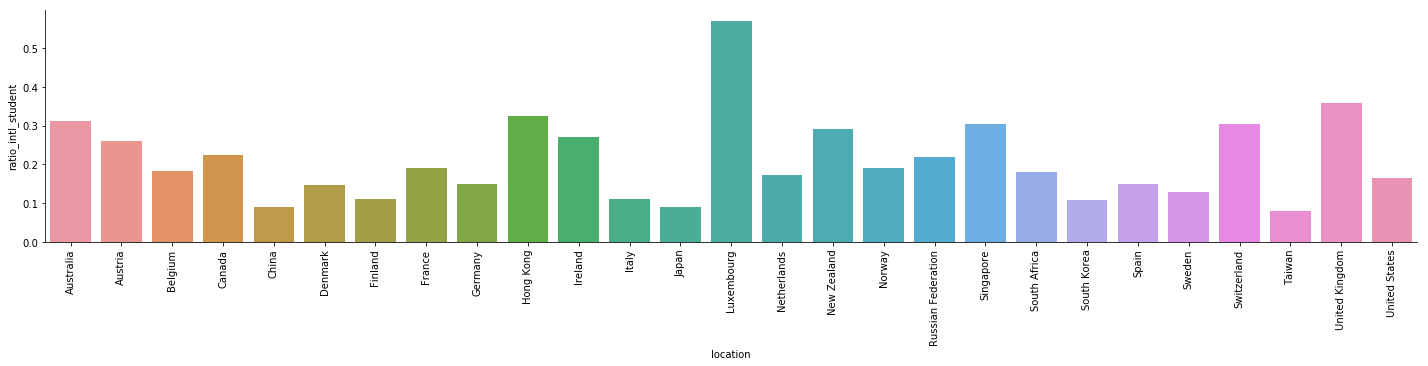

In [45]:
ax = sns.factorplot(kind = 'bar', x="location", y="ratio_intl_student", data=ranking_aggregated_country.reset_index(), aspect=5)
plt.xticks(rotation=90)
plt.show(ax)

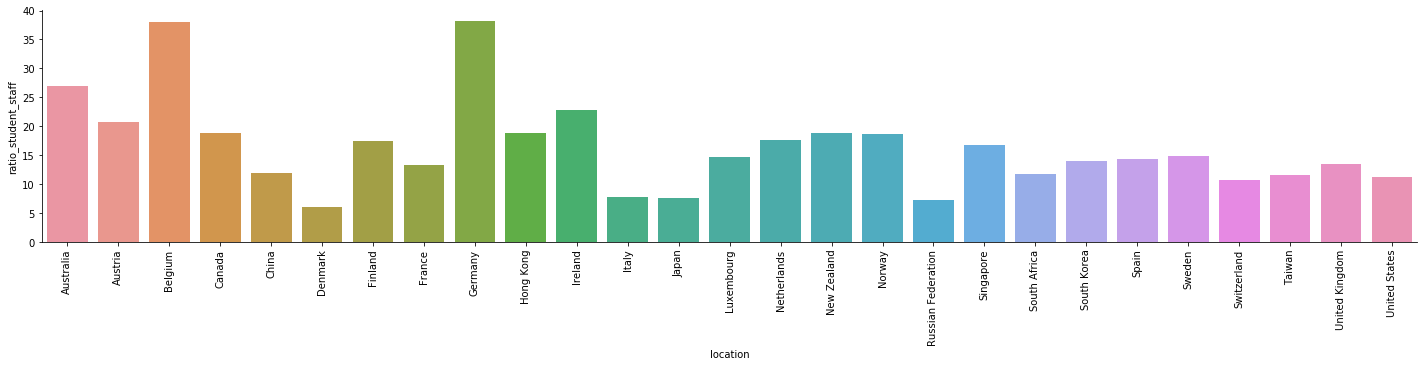

In [46]:
ax = sns.factorplot(kind = 'bar', x="location", y="ratio_student_staff", data=ranking_aggregated_country.reset_index(), aspect=5)
plt.xticks(rotation=90)
plt.show(ax)

And now aggregated by region: first sorted by ratio of international students and then by ratio of students to staff. We can see that Oceania has the highest international student ratio, while Asia has the lowest ratio. Also, Africa has the fewest students per staff while Oceania has the most.

In [47]:
ranking_aggregated_region = do_country_region_agg(ranking_w_region, 'region', cols_list)
ranking_aggregated_region.sort_values(ascending=False, by='ratio_intl_student').head(20)

,total_staff,total_intl_student,stats_number_students,ratio_intl_student,ratio_student_staff
region,,,,,
Oceania,11551,92607,298978.0,0.309745,25.883300
Europe,126816,481530,2143623.0,0.224634,16.903411
Africa,1775,3739,20775.0,0.179976,11.704225
North America,165553,336240,1954934.0,0.171996,11.808508
Asia,42628,78827,530949.0,0.148464,12.455405


In [48]:
ranking_aggregated_region.sort_values(ascending=True, by='ratio_student_staff').head(20)

,total_staff,total_intl_student,stats_number_students,ratio_intl_student,ratio_student_staff
region,,,,,
Africa,1775,3739,20775.0,0.179976,11.704225
North America,165553,336240,1954934.0,0.171996,11.808508
Asia,42628,78827,530949.0,0.148464,12.455405
Europe,126816,481530,2143623.0,0.224634,16.903411
Oceania,11551,92607,298978.0,0.309745,25.883300


Bar charts follow:

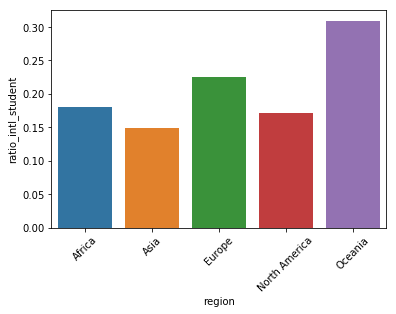

In [49]:
ax = sns.barplot(x="region", y="ratio_intl_student", data=ranking_aggregated_region.reset_index())
plt.xticks(rotation=45)
plt.show(ax)

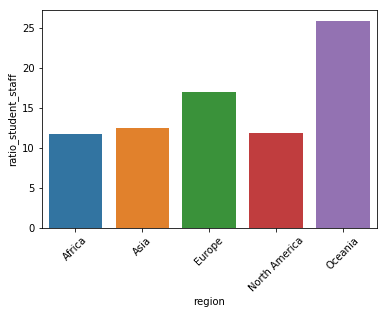

In [50]:
ax = sns.barplot(x="region", y="ratio_student_staff", data=ranking_aggregated_region.reset_index())
plt.xticks(rotation=45)
plt.show(ax)

Now, we have to merge the two dataframes. Our strategy is as follows:

* For each university in the topuniversities DataFrame, we find its closest match in the THE DataFrame and the result is added to the former DataFrame as a column called "closest".
* Then we join the two DataFrames based on the "name" column in THE and the "closest" column in the topuniversities.

After doing that, we found out that there were a handful of rows not matching, either because their names in the two tables were in different languages (one English, the other the actual native name of the university), because the name in one of the two was overly long or overly short and abbreviated, or because that university did not exist in the other table. In the latter case, we just ignore that university (and it's mostly universities with ranks close to 200, so they are not of very high importance), but in the former case, we identified them and fixed them by hand. The following are the 4 universities whose names in topuniversities we changed to be closer to their names in THE:

- Ludwig-Maximilians-Universität München: LMU Munich	
- Ruprecht-Karls-Universität Heidelberg: Heidelberg University
- Université Pierre et Marie Curie (UPMC): Pierre and Marie Curie University
- Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento: Scuola Superiore Sant'Anna

We also rename the columns of our dataset by adding THE to the beginning to avoid mixing them up with columns from the other dataset.

In [52]:
topunis_data["closest"]=topunis_data['name'].map(lambda x: difflib.get_close_matches(x, ranking_w_region["name"],n=1))

In [53]:
topunis_data["closest"]=topunis_data["closest"].apply(lambda x: x[0] if len(x)>0 else "")
topunis_data.loc[65,"closest"]="LMU Munich"
topunis_data.loc[67,"closest"]="Heidelberg University"
topunis_data.loc[130,"closest"]="Pierre and Marie Curie University"
topunis_data.loc[193,"closest"]="Scuola Superiore Sant’Anna"

the_columns_renamed = {col:'THE_'+col for col in ranking_w_region.columns}
ranking_w_region = ranking_w_region.rename(columns=the_columns_renamed)

topunis_data_cols_renamed = {col:'TOPU_'+col for col in topunis_data.columns}
topunis_data = topunis_data.rename(columns = topunis_data_cols_renamed)


We can see that not all universities have a match; some universities that fall within the top 200 in one database are not in the top 200 in the other. However, 189 out of 200 is still a pretty respectable number and shows that there is a lot of similarity between the two datasets.

In [54]:
pd.set_option('display.max_columns', 500)
merged_dataframes = pd.merge(ranking_w_region, topunis_data, left_on='THE_name', right_on='TOPU_closest')
merged_dataframes.shape


(189, 36)

In [55]:
merged_dataframes.head(10)

,THE_rank,THE_name,THE_location,THE_url,THE_scores_overall,THE_scores_teaching,THE_scores_research,THE_scores_citations,THE_scores_industry_income,THE_scores_international_outlook,THE_stats_number_students,THE_stats_student_staff_ratio,THE_stats_pc_intl_students,THE_region,THE_total_staff,THE_total_intl_student,TOPU_academic reputation score,TOPU_citations per faculty score,TOPU_employer reputation score,TOPU_faculty-student score,TOPU_international faculty score,TOPU_international students score,TOPU_country,TOPU_overall rank,TOPU_region,TOPU_stars,TOPU_name,TOPU_link,TOPU_total faculty,TOPU_international faculty,TOPU_total students,TOPU_international studets,TOPU_student-faculty ratio,TOPU_international student ratio,TOPU_international faculty ratio,TOPU_closest
0,1,University of Oxford,United Kingdom,/world-university-rankings/university-oxford,94.3,86.7,99.5,99.1,63.7,95.0,20409.0,11.2,0.38,Europe,1822,7755,100.0,76.3,100.0,100.0,98.6,98.5,United Kingdom,6,Europe,5,University of Oxford,/universities/university-oxford,6750.0,2964.0,19720.0,7353.0,0.342292,0.372870,0.439111,University of Oxford
1,2,University of Cambridge,United Kingdom,/world-university-rankings/university-cambridge,93.2,87.8,97.8,97.5,51.5,93.0,18389.0,10.9,0.35,Europe,1687,6436,100.0,78.3,100.0,100.0,97.4,97.7,United Kingdom,5,Europe,5,University of Cambridge,/universities/university-cambridge,5490.0,2278.0,18770.0,6699.0,0.292488,0.356899,0.414936,University of Cambridge
2,3,California Institute of Technology,United States,/world-university-rankings/california-institut...,93.0,90.3,97.5,99.5,92.6,59.7,2209.0,6.5,0.27,North America,339,596,99.5,100.0,85.4,100.0,93.4,89.2,United States,4,North America,5,California Institute of Technology (Caltech),/universities/california-institute-technology-...,953.0,350.0,2255.0,647.0,0.422616,0.286918,0.367261,California Institute of Technology
3,3,Stanford University,United States,/world-university-rankings/stanford-university,93.0,89.1,96.7,99.9,60.5,77.6,15845.0,7.5,0.22,North America,2112,3485,100.0,99.4,100.0,100.0,99.6,72.7,United States,2,North America,5,Stanford University,/universities/stanford-university,4285.0,2042.0,15878.0,3611.0,0.269870,0.227422,0.476546,Stanford University
4,5,Massachusetts Institute of Technology,United States,/world-university-rankings/massachusetts-insti...,92.5,87.3,91.9,100.0,88.4,87.6,11177.0,8.7,0.34,North America,1284,3800,100.0,99.9,100.0,100.0,100.0,96.1,United States,1,North America,6,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,2982.0,1679.0,11067.0,3717.0,0.269450,0.335863,0.563045,Massachusetts Institute of Technology
5,6,Harvard University,United States,/world-university-rankings/harvard-university,91.8,84.2,98.4,99.7,46.4,79.7,20326.0,8.9,0.26,North America,2283,5284,100.0,99.9,100.0,98.3,96.5,75.2,United States,3,North America,5,Harvard University,/universities/harvard-university,4350.0,1311.0,22429.0,5266.0,0.193945,0.234785,0.301379,Harvard University
6,6,Harvard University,United States,/world-university-rankings/harvard-university,91.8,84.2,98.4,99.7,46.4,79.7,20326.0,8.9,0.26,North America,2283,5284,68.5,35.1,59.5,85.0,NaN,NaN,Japan,122,Asia,None,Hokkaido University,/universities/hokkaido-university,2605.0,210.0,17552.0,1347.0,0.148416,0.076743,0.080614,Harvard University
7,7,Princeton University,United States,/world-university-rankings/princeton-university,91.1,85.7,93.9,99.6,58.0,78.7,7955.0,8.3,0.24,North America,958,1909,100.0,100.0,97.3,70.9,67.4,70.8,United States,13,North America,5,Princeton University,/universities/princeton-university,1007.0,246.0,8069.0,1793.0,0.124799,0.222208,0.244290,Princeton University
8,8,Imperial College London,United Kingdom,/world-university-rankings/imperial-college-lo...,89.2,81.7,88.7,96.7,71.6,96.6,15857.0,11.4,0.55,Europe,1390,8721,99.4,68.7,100.0,100.0,100.0,100.0,United Kingdom,8,Europe,None,Imperial College London,/universities/imperial-college-london,3930.0,2071.0,16090.0,

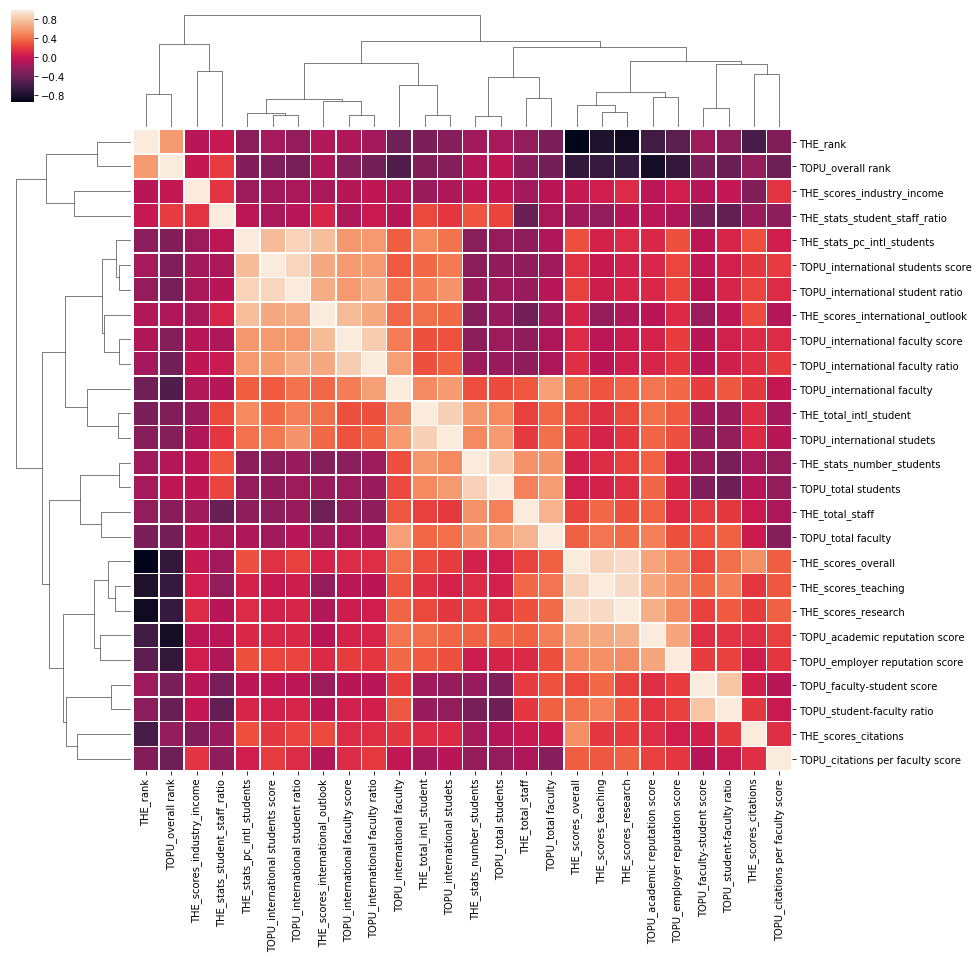

In [56]:
cg = sns.clustermap(merged_dataframes.corr(), linewidth=.5, figsize=(14,14))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
